In [1]:
import functools
import collections
import contextlib
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax import lax
from jax import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from tensorflow_probability.substrates.jax.internal.dtype_util
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfm = tfp.mcmc
tfed = tfp.experimental.distribute
tfde = tfp.experimental.distributions
tfem = tfp.experimental.mcmc

Root = tfed.JointDistributionCoroutine.Root
#matplotlib.use("Agg")  # noqa: E402

2022-12-13 17:42:17.692878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/opt/gsl/2.6/lib
2022-12-13 17:42:17.692945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/usr/local/cuda-11.7/lib64:/home/dkn16/.local/lib/python3.7/site-packages:/opt/gsl/2.

In [35]:
dim = 250
initial_states = jnp.load('states_toymodel_distributed.npy',allow_pickle = True)
kernel_var = jnp.array(initial_states[0])[:,0,:].reshape(1000).mean()
kernel_length = jnp.array(initial_states[2])[:,0,:].reshape(1000).mean()
kernel_noise = jnp.array(initial_states[1])[:,0,:].reshape(1000).mean()

kernel_var = jnp.tile(kernel_var,dim*dim)
kernel_length = jnp.tile(kernel_length,dim*dim)
kernel_noise = jnp.tile(kernel_noise,dim*dim)

In [36]:

# create artificial regression dataset
def get_data(dim=128):
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy').astype(jnp.float64)[:,0:dim,0:dim].transpose(2,1,0)
    
    #HI signal
    cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:dim,0:dim].transpose(2,1,0)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,150))/10000
    cosmos=cosmos.reshape((dim*dim,150))/10000
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1],dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1],dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [37]:
#dim = 250
#distribute our data on different GPUs
def shard_value(x):
    x = x.reshape((jax.device_count(), -1, *x.shape[1:]),order = 'C')
    return jax.pmap(lambda x: x)(x) # pmap will physically place values on devices

shard = functools.partial(jax.tree_map, shard_value)
X, Y, X_test = get_data(dim)

Y = shard(Y)
kernel_length = shard(kernel_length)
kernel_noise = shard(kernel_noise)
kernel_var = shard(kernel_var)
Y.shape

(4, 15625, 150)

In [ ]:
#This is 'one parameter for all'

from jax.experimental.host_callback import call
dtype = jnp.float64
#@jax.default_matmul_precision('float32')
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, None,0), out_axes=(None,None))
def run(seed, X, data):
    #data = Y # a sharded dataset
    num_examples, dim = data.shape
    #num_classes = 10
    # this is our model 
    def kernel1(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
        k = 10*var * jnp.exp(-0.5 * deltaXsq)
        #k = var * jnp.exp(-0.5 * deltaXsq)
        if is_noise:
            k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
        return k
    
    def model_fn():
        var = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        #print(var.shape
        noise = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        length = yield Root(tfd.Sample(tfd.InverseGamma(dtype(10.),dtype(2.)), 1))
        #logits = jnp.dot(images, w) + b
        k =  jax.vmap(lambda var,length,noise: kernel1(X, X, var, length, noise))(var,length,noise)
        #print(k.shape)
        yield tfed.Sharded(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros(dim,dtype=jnp.float64),covariance_matrix = k),
                           shard_axis_name='data')
    model = tfed.JointDistributionCoroutine(model_fn)

    init_seed, sample_seed = random.split(seed)

    initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`

    def target_log_prob(*state):
        return model.log_prob((*state, data)).mean()

    #def accuracy(w, b):
    #    logits = images.dot(w) + b
    #    preds = logits.argmax(axis=-1)
        # We take the average accuracy across devices by using `lax.pmean`
    #    return lax.pmean((preds == labels).mean(), 'data')

    kernel = tfm.NoUTurnSampler(target_log_prob, 1e-2,max_tree_depth=8)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel,500,target_accept_prob=0.8)
    def trace_fn(state, pkr):
        log_prob = target_log_prob(*state)
        call(lambda x: print(f"step: {x[0]},leap_frogs: {x[1]},step_size: {x[2]:.2g},accept_ratio:{x[3]:.3f},log_prob:{x[4]:.2f} \n "), (pkr.step,pkr.inner_results.leapfrogs_taken,pkr.new_step_size,10**pkr.inner_results.log_accept_ratio,log_prob))
        #call(lambda x: print(f"leap_frogs: {x}"), pkr.inner_results.leapfrogs_taken)
        #call(lambda x: print(f"step_size: {x}"), pkr.new_step_size)
        
        return (
            log_prob,
            pkr.inner_results.has_divergence,
            10**pkr.inner_results.log_accept_ratio,
            #accuracy(*state),
            pkr.new_step_size,
        )
    states, traces = tfm.sample_chain(
            num_results=1000,
            num_burnin_steps=1000,
            current_state=initial_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=sample_seed,
        )
    return states, traces

In [5]:
#This is different parameters for distinct sightlines. Of course hierachical GP is here.

from jax.experimental.host_callback import call
dtype = jnp.float64
#@jax.default_matmul_precision('float32')
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, None,0,0,0,0), out_axes=(1,None))
def run(seed, X, data,kernel_var,kernel_length,kernel_noise):
    Sharded = functools.partial(tfed.Sharded, shard_axis_name='data')
    
    #data = Y # a sharded dataset
    num_examples, dim = data.shape
    #num_classes = 10
    # this is our model 
    def kernel1(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
        k = 10*var * jnp.exp(-0.5 * deltaXsq)
        #k = var * jnp.exp(-0.5 * deltaXsq)
        if is_noise:
            k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
        return k
    def prior_fn():
        var_std = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), name = 'var_std'))
        #print(var.shape
        length_alpha = yield Root(tfd.Sample(tfd.LogNormal(dtype(2.5),dtype(2)), name = 'length_alpha'))
        length_beta = yield Root(tfd.Sample(tfd.LogNormal(dtype(0.5),dtype(2.)), name = 'length_beta'))
        var = yield Root(tfed.Sharded(tfd.Sample(tfd.HalfNormal(var_std,),num_examples,name = 'var'),shard_axis_name='data'))
        #print(var.shape
        noise = yield Root(tfed.Sharded(tfd.Sample(tfd.HalfNormal(dtype(1.),),num_examples,name = 'var'),shard_axis_name='data'))
        length = yield Root(tfed.Sharded(tfd.Sample(tfd.InverseGamma(dtype(length_alpha),dtype(length_beta)),num_examples,name = 'var'),shard_axis_name='data'))
        #logits = jnp.dot(images, w) + b
        return (var,length,noise)
    prior = tfed.JointDistributionCoroutine(prior_fn)
        
    
    def model_fn():
        var,length,noise = yield from prior_fn()
        k =  jax.vmap(lambda var,length,noise: kernel1(X, X, var, length, noise))(var,length,noise)
        #print(k.shape)
        yield tfed.Sharded(tfd.Independent(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros((num_examples,dim),dtype=jnp.float64),covariance_matrix = k),1),
                           shard_axis_name='data')
        
    #decorate the distribution to make it compatible with distributed setting
    model = tfed.JointDistributionCoroutine(model_fn)

    init_seed, sample_seed = random.split(seed)
    var_std,length_alpha,length_beta,var,noise,length = prior.sample(seed=init_seed,sample_shape = 4)# throw away `y`
    var_std = jnp.mean(var_std,axis = 0)
    #print(var)
    var = kernel_var
    length_alpha = jnp.mean(length_alpha,axis = 0)
    length_beta = jnp.mean(length_beta,axis = 0)
    length = kernel_length
    noise = kernel_noise
    #print(var)
    #initial_state.var_std = jnp.mean(initial_state.var_std,axis = 0)
    initial_state = (var_std,length_alpha,length_beta,var,length,noise)
    del var,length,noise
    
    
    #print(initial_state)

    def target_log_prob(*state):
        return model.log_prob((*state, data))
    
    momentum_distribution = tfed.JointDistributionSequential([
        tfd.Normal(dtype(0.), dtype(1.)),
        tfd.Normal(dtype(0.), dtype(1.)),
        tfd.Normal(dtype(0.), dtype(1.)),
        Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_examples],dtype=jnp.float64), 1.), 1)),
        Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_examples],dtype=jnp.float64), 1.), 1)),
        Sharded(tfd.Independent(tfd.Normal(jnp.zeros([num_examples],dtype=jnp.float64), 1.), 1)),
    ])

    #def accuracy(w, b):
    #    logits = images.dot(w) + b
    #    preds = logits.argmax(axis=-1)
        # We take the average accuracy across devices by using `lax.pmean`
    #    return lax.pmean((preds == labels).mean(), 'data')

    kernel = tfem.PreconditionedNoUTurnSampler(target_log_prob, 1e-3,max_tree_depth = 8,experimental_shard_axis_names=[None,None,None,"data","data","data"],momentum_distribution=momentum_distribution)
    #kernel = tfem.GradientBasedTrajectoryLengthAdaptation(kernel,500)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel,800)
    def trace_fn(state, pkr):
        log_prob = target_log_prob(*state)
        call(lambda x: print(f"step: {x[0]},leap_frogs: {x[1]},step_size: {x[2]:.2g},accept_ratio:{x[3]:.3g},log_prob:{x[4]:.2f} \n "), (pkr.step,pkr.inner_results.leapfrogs_taken,pkr.new_step_size,10**pkr.inner_results.log_accept_ratio,log_prob))
        #call(lambda x: print(f"iter: {x[0]},log_prob:{x[1]:.2f} \n "), (pkr.step,log_prob))
        #call(lambda x: print(f"step_size: {x}"), pkr.new_step_size)
        
        return (
            log_prob,
            pkr.inner_results.has_divergence,
            #pkr.has_divergence,
            10**pkr.inner_results.log_accept_ratio,
            #10**pkr.log_accept_ratio,
            #accuracy(*state),
            #pkr.new_step_size,
        )
    states, traces = tfm.sample_chain(
            num_results=10,
            #num_burnin_steps=1000,
            current_state=initial_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=sample_seed,
        )
    return states, traces

In [7]:
%%time
states,trace = run(random.PRNGKey(42),X,Y,kernel_var,kernel_length,kernel_noise)
#jnp.save('states.npy',{f'param_{i}':states[i] for i in range(len(states))})

step: 0,leap_frogs: 0,step_size: 0.001,accept_ratio:1,log_prob:-2865598055663.11 
 step: 0,leap_frogs: 0,step_size: 0.001,accept_ratio:1,log_prob:-2865598055663.11 
 
step: 0,leap_frogs: 0,step_size: 0.001,accept_ratio:1,log_prob:-2865598055663.11 
 
step: 0,leap_frogs: 0,step_size: 0.001,accept_ratio:1,log_prob:-2865598055663.11 
 

step: 1,leap_frogs: 1,step_size: 0.0026,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 1,leap_frogs: 1,step_size: 0.0026,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 1,leap_frogs: 1,step_size: 0.0026,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 1,leap_frogs: 1,step_size: 0.0026,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 2,leap_frogs: 1,step_size: 0.00029,accept_ratio:0,log_prob:-2865598055663.11 
 step: 2,leap_frogs: 1,step_size: 0.00029,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 2,leap_frogs: 1,step_size: 0.00029,accept_ratio:0,log_prob:-2865598055663.11 
 
step: 2,leap_frogs: 1,step_size: 0.00029,accept_ratio:0,log_prob:-2

In [76]:
kernel_var = states['param_3'][500:1000:10]
kernel_noise = states['param_4'][500:1000:10]
kernel_length = states['param_5'][500:1000:10]
kernel_var = kernel_var.reshape((50,-1))
kernel_var[:,232]

DeviceArray([1.47654663, 1.47642227, 1.47454004, 1.47559296, 1.475645  ,
             1.47580998, 1.47592621, 1.4753079 , 1.47655958, 1.47660082,
             1.47670953, 1.47659245, 1.47626661, 1.47752844, 1.47470198,
             1.47230087, 1.47396416, 1.47386397, 1.46987925, 1.46943403,
             1.4696082 , 1.47000592, 1.46656752, 1.46696148, 1.47149513,
             1.47176212, 1.472868  , 1.47325726, 1.4773522 , 1.47749597,
             1.47842766, 1.47771116, 1.47721837, 1.4774301 , 1.47659245,
             1.47636019, 1.47628032, 1.47444085, 1.47379966, 1.47343997,
             1.47155037, 1.47126697, 1.47321096, 1.4707005 , 1.47099918,
             1.47061731, 1.4706284 , 1.47077424, 1.47062294, 1.47174416],            dtype=float64)

In [38]:
#dim = 250
X, Y, X_test = get_data(dim)
Y = Y.reshape((4,int(dim**2/4),150))
states = jnp.load('states_toymodel_distributed_hierachy.npy',allow_pickle=True).item()
for keys in states.keys():
    print(states[keys].shape)

(1000, 4)
(1000, 4)
(1000, 4)
(1000, 4, 15625)
(1000, 4, 15625)
(1000, 4, 15625)


In [39]:
from jax import vmap
#states[0][0]
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = 10*var * jnp.exp(-0.5 * deltaXsq)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
    return k

@jax.jit
def predict(rng_key, X, Y, X_test, var, length, noise):
    X=jnp.repeat(jnp.array([X]),Y.shape[0],axis=0)
    # compute kernel of size (4096,150,150)
    vmap_args = (
        X,X,var,length,noise
    )
    
    k_pp = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=False
        )
    )(*vmap_args)
    k_pX = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=False
        )
    )(*vmap_args)
    k_XX = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=True
        )
    )(*vmap_args)
    
    #compute some useful matrix
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jax.lax.batch_matmul(k_pX, jax.lax.batch_matmul(K_xx_inv, jnp.transpose(k_pX,axes=(0,2,1))))
    
    vmap_args = (
        K_xx_inv,Y
    )
    cache = vmap(lambda A,B: jnp.matmul(A,B))(*vmap_args)
    vmap_args = (
        k_pX,cache
    )
    mean = vmap(lambda A,B: jnp.matmul(A,B))(*vmap_args)
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean

kernel_var = states['param_3'][500:1000:10]
kernel_noise = states['param_4'][500:1000:10]
kernel_length = states['param_5'][500:1000:10]
rng_key, rng_key_predict = random.split(random.PRNGKey(42))
means = []
for i in range(50):
    #print(j)
    cache = []
    for j in range(4):
        print(f'iter = {4*i+j}')
        cache.append(predict(
           rng_key, X, Y[j], X, kernel_var[i][j], kernel_length[i][j], kernel_noise[i][j]
        ))
    means.append(cache)
means = jnp.array(means)
means.shape
#print(means）

#mean_prediction = np.mean(means, axis=0)
#percentiles = np.percentile(means, [5.0, 95.0], axis=0)

iter = 0
iter = 1
iter = 2
iter = 3
iter = 4
iter = 5
iter = 6
iter = 7
iter = 8
iter = 9
iter = 10
iter = 11
iter = 12
iter = 13
iter = 14
iter = 15
iter = 16
iter = 17
iter = 18
iter = 19
iter = 20
iter = 21
iter = 22
iter = 23
iter = 24
iter = 25
iter = 26
iter = 27
iter = 28
iter = 29
iter = 30
iter = 31
iter = 32
iter = 33
iter = 34
iter = 35
iter = 36
iter = 37
iter = 38
iter = 39
iter = 40
iter = 41
iter = 42
iter = 43
iter = 44
iter = 45
iter = 46
iter = 47
iter = 48
iter = 49
iter = 50
iter = 51
iter = 52
iter = 53
iter = 54
iter = 55
iter = 56
iter = 57
iter = 58
iter = 59
iter = 60
iter = 61
iter = 62
iter = 63
iter = 64
iter = 65
iter = 66
iter = 67
iter = 68
iter = 69
iter = 70
iter = 71
iter = 72
iter = 73
iter = 74
iter = 75
iter = 76
iter = 77
iter = 78
iter = 79
iter = 80
iter = 81
iter = 82
iter = 83
iter = 84
iter = 85
iter = 86
iter = 87
iter = 88
iter = 89
iter = 90
iter = 91
iter = 92
iter = 93
iter = 94
iter = 95
iter = 96
iter = 97
iter = 98
iter = 99
iter = 100

(50, 4, 15625, 150)

In [16]:
jnp.save('means.npy',means)

In [40]:
#del states,kernel_var,kernel_length,kernel_noise
#means = jnp.load('means.npy')


means = means.reshape((50,-1,150))

mean_prediction = jnp.mean(means, axis=0)
percentiles = np.percentile(means, [5.0, 95.0], axis=0)
#mean_prediction = means.reshape((-1,150))

In [41]:
#kernel_var

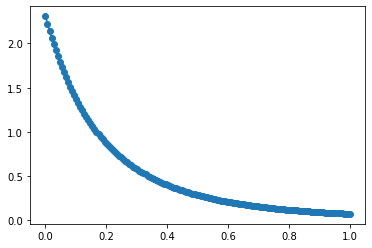

In [42]:
#dim = 4
#X, Y2, X_test = get_data(dim)
Y1=Y.reshape((-1,150))
#print(Y2-Y1)

plt.fill_between(X, percentiles[0, 100,:], percentiles[1, 100,:], color="lightblue")
plt.scatter(X,Y1[100])
plt.plot(X,mean_prediction[100])


In [81]:
states[1][:,0]

DeviceArray([0.83950087, 0.36073317, 0.73493597, 0.41453962, 0.50970339,
             0.63965067, 0.61998765, 0.43822609, 0.66496476, 0.44595276,
             0.75141742, 0.68484405, 0.54684694, 0.63224511, 0.65610096,
             0.59906263, 0.69051995, 0.4705189 , 0.55511178, 0.57720229,
             0.61407266, 0.46584613, 0.52750512, 0.73340256, 0.56409814,
             0.56526016, 0.79721991, 0.55974174, 0.60599168, 0.37837426,
             0.61570589, 0.61278358, 1.17898065, 0.87204535, 0.58943367,
             0.40431446, 0.48301379, 0.64736186, 0.49142885, 0.76873862,
             0.61679432, 0.91984997, 0.88398955, 0.8761867 , 0.88255139,
             0.87530896, 0.88673986, 0.89348142, 0.89675928, 1.02742208,
             0.91984688, 0.93434894, 0.84834937, 0.83209624, 0.65483079,
             0.66949001, 0.69697545, 0.69697545, 0.65102389, 0.67557555,
             0.69098227, 0.69000591, 0.67017674, 0.60972186, 0.78501976,
             0.79363557, 0.71641989, 0.78743064, 0.

In [43]:
cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:dim,0:dim].transpose(2,1,0)
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(dim*dim,150)

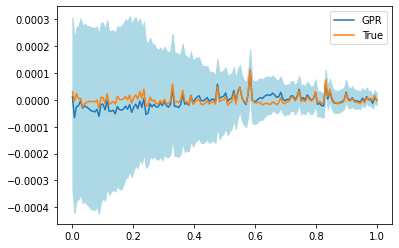

In [53]:
i=234
plt.plot(X,Y1[i]-mean_prediction[i])

plt.plot(X,cosmos[i]/10000)
plt.fill_between(X_test,Y1[i]-percentiles[0, i,:], Y1[i]-percentiles[1, i,:], color="lightblue")
plt.legend(['GPR','True'])

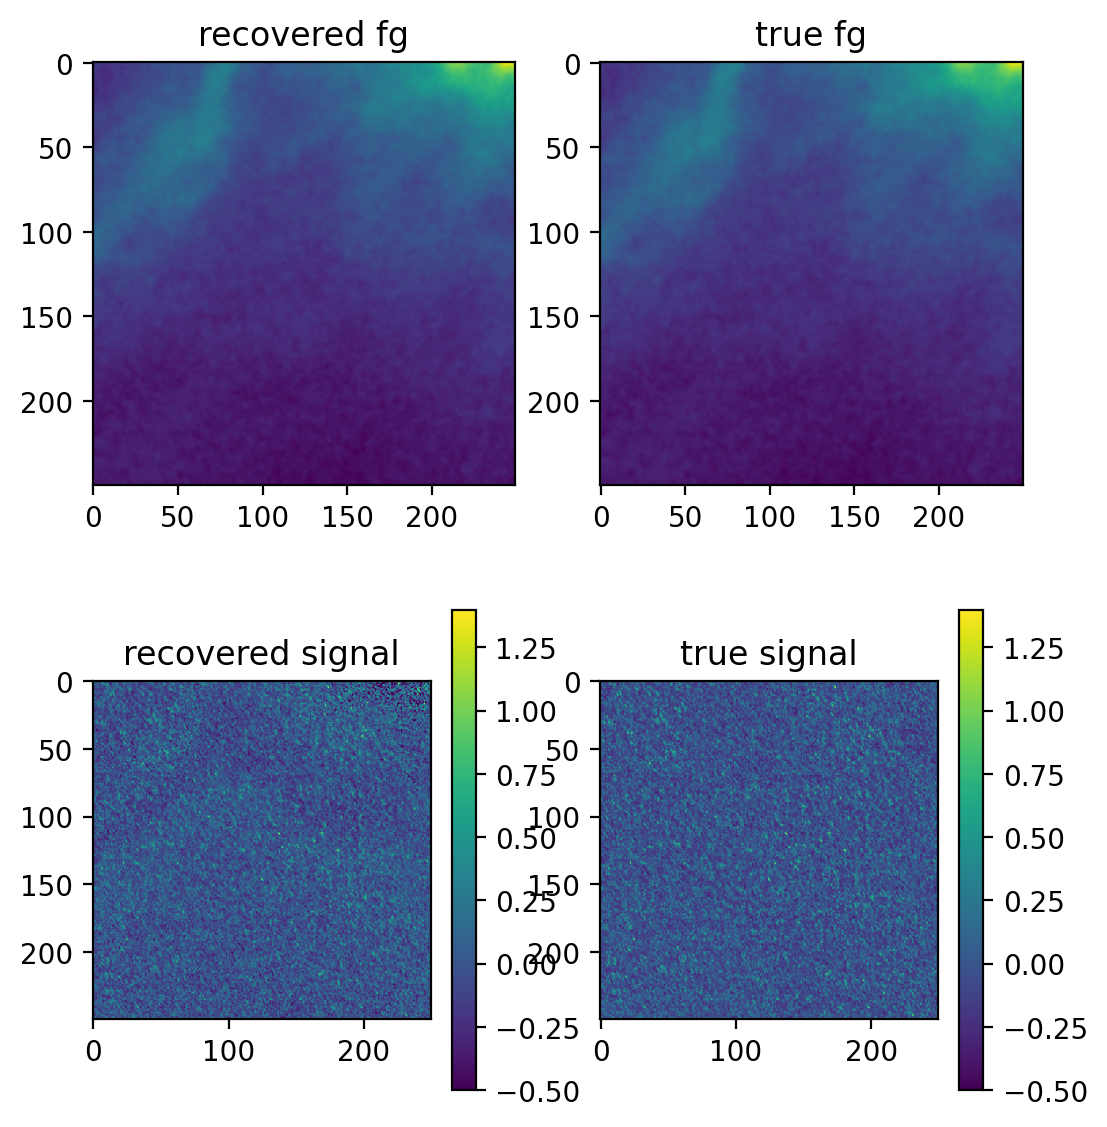

In [45]:
i=20
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(250,250))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y1[:,i].reshape(250,250))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y1[:,i]-mean_prediction[:,i]).reshape(250,250)*10000,vmin=-0.5,vmax=1.4)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(250,250),vmin=-0.5,vmax=1.4)
plt.title('true signal')
plt.colorbar()

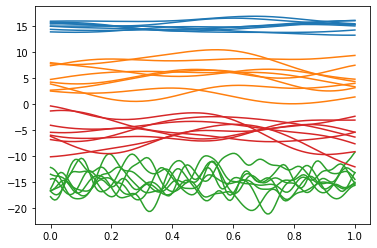

In [25]:
k1 = kernel(X, X,  0.052016747, 0.23297304, 1.81647456)
k2 = kernel(X, X,  1.52016747, 0.23297304, 1.81647456)
k3 = kernel(X, X,  0.52016747, 0.23297304, 1.81647456)
k4 = kernel(X, X,  0.52016747, 0.03297304, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=[[k1,k2],[k3,k4]]),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i][0][0]+15,c='tab:blue')
    plt.plot(X,samp[i][1][0]+5,c='tab:orange')
    plt.plot(X,samp[i][0][1]-5,c='tab:red')
    plt.plot(X,samp[i][1][1]-15,c='tab:green')

In [160]:
numpyro.sample("kernel_var", dist.InverseGamma(10,2),rng_key= rng_key,sample_shape=(16,))

DeviceArray([0.16593575, 0.35661613, 0.44178466, 0.23166905, 0.19851243,
             0.26369422, 0.13496179, 0.21433583, 0.18115296, 0.14783476,
             0.28515543, 0.13975012, 0.13496239, 0.17410843, 0.21726044,
             0.12075873], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [170]:
samples

{'kernel_length': DeviceArray([0.42302552, 0.42301878, 0.42302362, 0.42301987, 0.42302611,
              0.42302386, 0.42301263, 0.42300984, 0.42300949, 0.42300693,
              0.42301815, 0.42301443, 0.42302797, 0.42303227, 0.42302964,
              0.4230277 , 0.42303511, 0.42303283, 0.42303401, 0.42303393,
              0.4230301 , 0.42302349, 0.42302522, 0.42302567, 0.42302858,
              0.42303519, 0.42303757, 0.42303275, 0.42303534, 0.42304212,
              0.42303208, 0.42303007, 0.42303806, 0.42303085, 0.42302919,
              0.42302831, 0.42302581, 0.42301978, 0.42301602, 0.42301501,
              0.42300887, 0.42299479, 0.42298329, 0.42298619, 0.42299007,
              0.42299533, 0.422989  , 0.42298821, 0.42299028, 0.42298966],            dtype=float64),
 'kernel_noise': DeviceArray([1.80610243, 1.80609536, 1.80603133, 1.80598893, 1.8059467 ,
              1.80592032, 1.8059154 , 1.80593716, 1.80591137, 1.80589166,
              1.80587565, 1.80587742, 1.80590157, 1

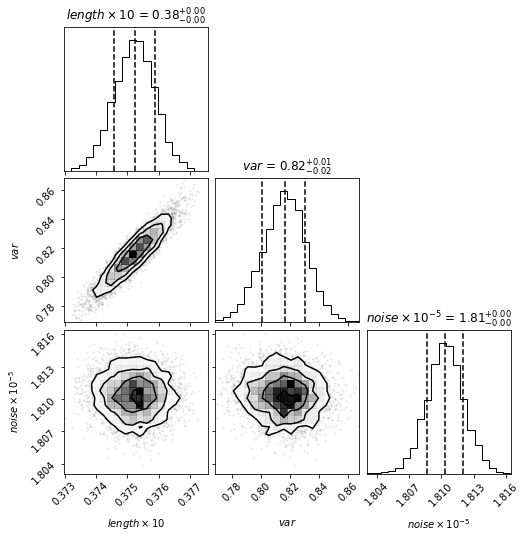

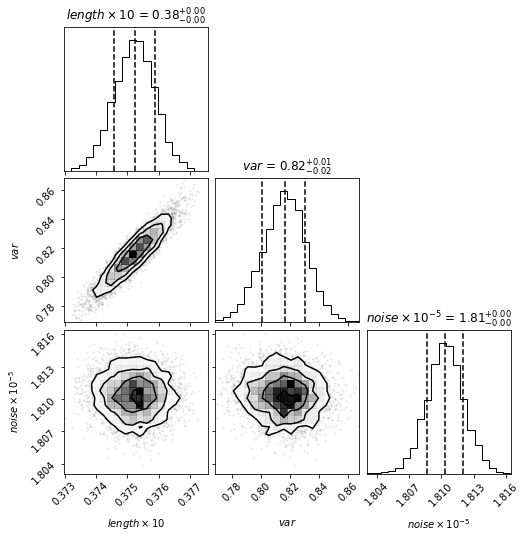

In [16]:
import corner
data = np.vstack([samples['kernel_length'],samples['kernel_var'],samples['kernel_noise']]).T
corner.corner(data,labels=[
        r"$length\times 10$",
        r"$var$",
        r"$noise\times 10^{-5}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [22]:
samp.shape

(8, 2, 2, 150)

In [21]:
Y.shape

(2, 2048, 150)

In [82]:
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
res = tfd.Sample(tfd.InverseGamma(0.839,0.76),100).sample(seed=rng_key)
res

DeviceArray([1.5263573e+01, 3.7834172e+00, 1.3629661e+00, 2.5673893e-01,
             1.6830805e-01, 3.9591877e+00, 5.1650290e+00, 1.3950026e+00,
             5.0936878e-01, 1.8319271e+00, 5.2577000e+00, 5.8795447e+00,
             3.3574653e+00, 1.6808580e+00, 1.4058294e+00, 1.3448144e+00,
             3.0148025e+00, 2.2515272e-01, 9.6795187e+00, 6.1777061e-01,
             9.9556780e-01, 6.4891994e-01, 3.5222024e-01, 5.6032091e-01,
             3.4869092e+00, 1.0898714e+00, 3.4692815e-01, 1.6163397e+00,
             4.9841437e+00, 2.4075611e+00, 1.1083497e+00, 3.0334858e+01,
             1.3154223e+00, 3.6237700e+00, 5.5545694e-01, 3.7367245e+01,
             8.3822185e-01, 3.6021533e+00, 5.5599312e+01, 1.4398533e+00,
             4.4916148e+00, 2.9878371e+00, 2.1184845e+01, 6.4471519e-01,
             1.5750953e+00, 1.1600139e+00, 6.8681798e+00, 7.7589858e-01,
             6.1439383e-01, 2.1830959e+00, 8.6282897e-01, 1.6242114e-01,
             4.3943157e+01, 9.1612297e-01, 3.504909